In [2]:
# Libraries
from sklearn.model_selection import train_test_split
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Dataset, Example
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

In [3]:
raw_data = pd.read_csv("./fake_job_postings.csv", engine='python', on_bad_lines='skip')

device = torch.device('cuda')
raw_data.drop( raw_data[raw_data['description'].str.split().str.len() < 5].index, inplace=True)
raw_data.drop( raw_data[raw_data['requirements'].str.split().str.len() < 5].index, inplace=True)
raw_data['fraudulent'] = raw_data['fraudulent'].astype('int')

raw_data = raw_data.reindex(columns=['fraudulent', 'title', 'description', 'requirements'])

real_data = raw_data[raw_data['fraudulent'] == 0]
fake_data = raw_data[raw_data['fraudulent'] == 1]

# downsample to balance the data
# real_data = real_data[:(len(fake_data)*10)]
print("real len: ", len(real_data))
print("fake len: ", len(fake_data))

train_test_ratio = 0.10
train_valid_ratio = .80
real_full_train, real_test = train_test_split(real_data, train_size = train_test_ratio, random_state=42)
fake_full_train, fake_test = train_test_split(fake_data, train_size = train_test_ratio, random_state=42)
real_train, real_valid = train_test_split(real_full_train, train_size = train_valid_ratio, random_state=42)
fake_train, fake_valid = train_test_split(fake_full_train, train_size = train_valid_ratio, random_state=42)
train = pd.concat([real_train, fake_train], ignore_index=True, sort=False)
valid = pd.concat([real_valid, fake_valid], ignore_index=True, sort=False)
test = pd.concat([real_test, fake_test], ignore_index=True, sort=False)
train_csv = train
train.to_csv('./train.csv', index=False)
valid.to_csv('./valid.csv', index=False)
test.to_csv('./test.csv', index=False)

real len:  16864
fake len:  821


In [39]:
# hyperparams
epochs = 20
hidden = 16
batch_size = 8
dropout = .5
learning_rate = .001

label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field( lower=True, include_lengths=True, batch_first=True)
fields = [('fraudulent', label_field), ('title', text_field), ('description', text_field), ('requirements', text_field)]
train, valid, test = TabularDataset.splits(path='./', train='train.csv', validation='valid.csv', test='test.csv',
                                           format='CSV', fields=fields, skip_header=True)

train_iter = BucketIterator(train, batch_size=batch_size, sort_key=lambda x: len(x.title),
                            device=device, sort=True, sort_within_batch=True)
valid_iter = BucketIterator(valid, batch_size=batch_size, sort_key=lambda x: len(x.title),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=batch_size, sort_key=lambda x: len(x.title),
                            device=device, sort=True, sort_within_batch=True)

text_field.build_vocab(train, min_freq=3)

class LSTM(nn.Module):
    def __init__(self, dimension):
        super(LSTM, self).__init__()
        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True)
        self.drop = nn.Dropout(p=dropout)
        self.linear = nn.Linear(dimension,1)
  
    def forward(self, text, text_len):
        embedding = self.embedding(text)
        packed_input = pack_padded_sequence(embedding, text_len, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        unpacked_output, _ = pad_packed_sequence(packed_output, batch_first=True)
        output = unpacked_output[range(len(unpacked_output)), text_len - 1, :self.dimension]

        output = self.drop(output)

        output = self.linear(output)
        output = torch.squeeze(output)
        output = torch.sigmoid(output)

        return output

def BCELoss_weighted(weights):
    def loss(input, target):
        input = torch.clamp(input,min=1e-7, max=1-1e-7)
        bce = -weights[1] * target * torch.log(input) - (1 - target) * weights[0] * torch.log(1-input)
        return torch.mean(bce)
    
    return loss

Epoch: 1 of 20, Step: 23 of 920, Train Loss: 0.9193, Validation Loss: 1.3252
Epoch: 1 of 20, Step: 46 of 920, Train Loss: 2.1012, Validation Loss: 1.2666
Epoch: 2 of 20, Step: 69 of 920, Train Loss: 0.8711, Validation Loss: 1.2668
Epoch: 2 of 20, Step: 92 of 920, Train Loss: 1.7482, Validation Loss: 1.2578
Epoch: 3 of 20, Step: 115 of 920, Train Loss: 0.8960, Validation Loss: 1.2598
Epoch: 3 of 20, Step: 138 of 920, Train Loss: 1.7015, Validation Loss: 1.2584
Epoch: 4 of 20, Step: 161 of 920, Train Loss: 0.8540, Validation Loss: 1.2575
Epoch: 4 of 20, Step: 184 of 920, Train Loss: 1.6342, Validation Loss: 1.2522
Epoch: 5 of 20, Step: 207 of 920, Train Loss: 0.8657, Validation Loss: 1.2495
Epoch: 5 of 20, Step: 230 of 920, Train Loss: 1.6078, Validation Loss: 1.2474
Epoch: 6 of 20, Step: 253 of 920, Train Loss: 0.8508, Validation Loss: 1.2470
Epoch: 6 of 20, Step: 276 of 920, Train Loss: 1.4495, Validation Loss: 1.2487
Epoch: 7 of 20, Step: 299 of 920, Train Loss: 0.8321, Validation Los

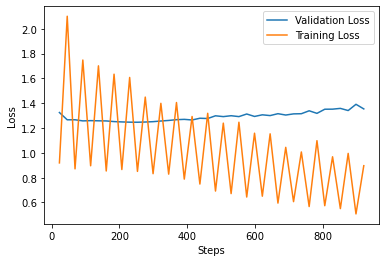

In [48]:
def train(model, 
          optimizer,  
          criterion=BCELoss_weighted([1, len(real_data) / len(fake_data)]), 
#           criterion=nn.BCELoss(),
          checkpoint = len(train_iter) // 2):
    
    train_losses = []
    valid_losses = []
    steps = []

    running_loss = 0.0
    valid_running_loss = 0.0
    step = 0
    
    model.train()
    for epoch in range(epochs):
        for (labels, (title, title_len), (description, description_len), (req, req_length)), _ in train_iter:
            labels = labels.to(device)
            text = torch.cat((description, req), dim=-1)
            text_len = torch.add(description_len, req_length)
#             text = description
#             text_len = description_len
            #print(description_len.size())
            text = text.to(device)
            text_len = text_len.to(torch.device('cpu'))
            output = model(text, text_len)
        

            #print(labels)
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            step += 1

            if step % checkpoint == 0:
                model.eval()
                with torch.no_grad():                    
                    for (labels, (title, title_len), (description, description_len), (req, req_len)), _ in valid_iter:
                       
                        labels = labels.to(device)
                        text = torch.cat((description, req), dim=-1)
                        text_len = torch.add(description_len, req_len)
#                         text = description
#                         text_len = description_len
                        text = text.to(device)
                        text_len = text_len.to(torch.device('cpu'))
                        output = model(text, text_len)
                        
                        
                        loss = criterion(output, labels)
                        valid_running_loss += loss.item()

                average_train_loss = running_loss / checkpoint
                average_valid_loss = valid_running_loss / len(valid_iter)
                train_losses.append(average_train_loss)
                valid_losses.append(average_valid_loss)
                steps.append(step)

                running_loss = 0.0                
                valid_running_loss = 0.0
                model.train()

                print('Epoch: {} of {}, Step: {} of {}, Train Loss: {:.4f}, Validation Loss: {:.4f}'
                          .format(epoch+1, epochs, step, epochs*len(train_iter),
                                  average_train_loss, average_valid_loss))
                
    plt.plot(steps, valid_losses, label="Validation Loss")
    plt.plot(steps, train_losses, label="Training Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.legend()
    
    print(valid_losses)

model = LSTM(dimension=hidden).to(device)

train(model=model, optimizer=optim.Adam(model.parameters(), lr=learning_rate))
torch.save(model.state_dict(), "model.pt")


    

encountered empty description, skipping
              precision    recall  f1-score   support

           1     0.1330    0.1618    0.1460       723
           0     0.9162    0.8967    0.9064      7389

    accuracy                         0.8312      8112
   macro avg     0.5246    0.5293    0.5262      8112
weighted avg     0.8464    0.8312    0.8386      8112



[Text(0, 0.5, 'FRAUDULENT'), Text(0, 1.5, 'REAL')]

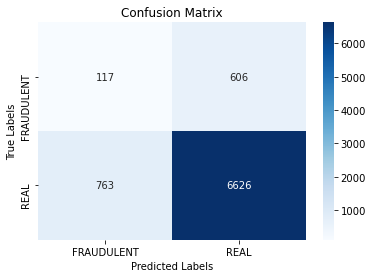

In [50]:
# test model
model.load_state_dict(torch.load("model.pt"))
model.eval()
with torch.no_grad():
    predictions = []
    actual = []
    for (labels, (title,title_len), (description, description_len), (req, req_len)), _ in test_iter:
        try:
            labels = labels.to(device)
            description = description.to(device)
            description_len = description_len.to(torch.device('cpu'))
            output = model(description, description_len)
            output = (output > .5).int()
            predictions.extend(output.tolist())
            actual.extend(labels.tolist())
        except:
            print("encountered empty description, skipping")
#             print(description)
#             print(description_len)
   
print(classification_report(actual, predictions, labels=[1,0], digits=4))
cm = confusion_matrix(actual, predictions, labels=[1,0])
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

ax.set_title('Confusion Matrix')

ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')

ax.xaxis.set_ticklabels(['FRAUDULENT', 'REAL'])
ax.yaxis.set_ticklabels(['FRAUDULENT', 'REAL'])

[0.55, 5.5]